# 0. Imports

In [ ]:
import pandas as pd
import numpy as np
import requests as rq
import bs4
import lxml
import json
import os
import time
from dateutil import parser
import pickle 
import functools
import heapq

import collections
from collections import Counter

from sklearn.feature_extraction.text import TfidfVectorizer

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import *
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

nltk.download('stopwords')
nltk.download('punkt')

# 1. Data collection

The methods in this section have been used to aquire all the data later used in this notebook.
Since we uploaded all the data to GitHub and the methods take a long time to complete, it is not
recommended to run them.

## 1.1 Get the list of places

In [9]:
def fetch_places(top_places_url="https://www.atlasobscura.com/places?sort=likes_count"):
    """
    This method fetches all the URLs from atlasobscura and writes them to a .txt file.
    Disclaimer: It takes a long time!
    """
    
    home_url = "https://www.atlasobscura.com"
    top_places = []
    N = 400 # number of pages
    
    for _ in range(N): 

        if _ % 50 == 0: # print process
            print(page_url)

        time.sleep(0.01) # sleep to avoid too many requests
        result = rq.get(page_url)
        soup = bs4.BeautifulSoup(result.text)

        # acess all 18 cards of the current page
        cards = soup.find_all("div", {"class": "col-md-4 col-sm-6 col-xs-12"})
        # len(cards) = 18

        # only store the href for each card
        page_urls = [card.find_all("a", {"class": "content-card content-card-place"})[0].get('href') 
                     for card in cards]

        top_places.append(page_urls)

        # acess url for the next page from the "next page" button
        next_page = soup.find_all("a", {"rel": "next"})[0].get('href')
        page_url = home_url + next_page
    
    # write all urls to one .txt file
    with open("places.txt", 'w+') as f:
        for page in top_places:
            for place in page:
                f.write(place + '\n')

In [7]:
with open("places.txt", 'r') as f:
    lines = f.readlines()

print('Number of places fetched:', len(lines))

Number of places fetched: 7200


## 1.2 Crawl places

In [10]:
# method for writing .html files for the set of urls for one page
def crawl_places(path_to_place_urls,
                 parent_dir="htmls"):
    """
    This method reads the URLs from the places.txt and creates folders according to the pages
    containing the .html files for each place.
    """
    
    # read and split urls in 400 sets of 18
    with open(path_to_place_urls, 'r+') as f:
        lines = [line.strip() for line in f.readlines()]
        top_places = np.array_split(lines, 400)
    
    # iterate through pages
    for page_ix, urls_per_page in enumerate(top_places, start=1):
        # create folder per page
        directory = f'page_{page_ix}'
        path = os.path.join(parent_dir, directory)
        os.mkdir(path)
        
        # iterate through places per page
        for place_ref in urls_per_page:
            place_ref = place_ref[:-1]

            time.sleep(5) # sleep to avoid too many requests error
            page = rq.get(place_ref)
            place_name = place_ref.split('/')[-1].replace('-', '_')
            
            # write to .html file
            with open(f'{path}/{place_name}.html', 'wb+') as f:
                f.write(page.content)


## 1.3  Parse downloaded pages

In [12]:
def get_place_attributes(soup, tsv_dir):
    """
    This method creates extracts all the attributes from the html code and writes it to a 
    tsv file.
    """
    
    placeName = str(soup.find_all('h1',{'class':'DDPage__header-title'})[0].contents[0])
    
    try:
        placeTags = str(soup.find_all('div',{'class':'DDPage__header-place-location'})[0].contents[0].text).split(sep=',')
    except:
        placeTags = ''
    
    numPeopleVisited = int(soup.find_all('div', {'class':'title-md item-action-count'})[0].contents[0])
    
    numPeopleWant = int(soup.find_all('div', {'class':'title-md item-action-count'})[-1].contents[0])
    
    placeDesc = soup.find_all('div', {'class':'DDP__body-copy'})[0].text.strip()
    
    placeShortDesc = soup.find_all('h3', {'class':'DDPage__header-dek'})[0].text
    
    placeAddress = soup.find_all('address', {'class':'DDPageSiderail__address'})[0].contents[3].text.partition('\n')[0]
    
    list_Alt_Long = soup.find_all('address', {'class':'DDPageSiderail__address'})[0].contents[3].text
    
    placeAlt = int(float(list_Alt_Long.split('\n', 1)[1].split()[0].replace(',', ' ')))
    
    placeLong = int(float(list_Alt_Long.split('\n', 1)[1].split()[1].replace(',', ' ')))

    placeEditors = soup.find_all('div', {'class':'js-editor-list hidden'})
    if len(placeEditors) == 0:
        placeEditors = list()
    else:
        placeEditors = soup.find_all('div', {'class':'js-editor-list hidden'})[0].text.split()
    
    for elem in placeEditors:
        if len(elem) == 1:
            placeEditors.remove(elem)

    placePubDate = soup.find_all('div', {'class':'DDPContributor__name'})
    if len(placePubDate) > 0:
        placePubDate = placePubDate[0].text.replace(',', ' ')
        placePubDate = parser.parse(placePubDate).date() # %y-%m-%d
    else:
        placePubDate = ''
        
    card_grids = soup.find_all('div', 
                               {'class': "card-grid CardRecircSection__card-grid js-inject-gtm-data-in-child-links"
    })
    
    if len(card_grids) >= 2:
        second_card = card_grids[1]
        placeRelatedPlaces = [button.get("data-place-title") 
                              for button in second_card.find_all('div', 
                                                                 {'class': 'Card__action-btns vue-js-been-there-everywhere-place'})]
    else:
        placeRelatedPlaces = ''

    if len(card_grids) >= 3:
        third_card = card_grids[2]
        placeRelatedLists = [related_list.text.strip()
                             for related_list in third_card.find_all('h3', 
                                                                     {'class': 'Card__heading --content-card-v2-title js-title-content'})]
    else:
        placeRelatedLists = ''

    placeURL = soup.find_all('link', {'rel': "canonical"})[0].get('href')

    df = pd.DataFrame({'placeName' : placeName, 
                      'placeTags' : [placeTags],
                      'numPeopleVisited': numPeopleVisited,
                      'numPeopleWant': numPeopleWant,
                      'placeDesc': placeDesc,
                      'placeShortDesc': placeShortDesc,
                      'placeAddress': placeAddress, 
                      'placeAlt': placeAlt,
                      'placeLong': placeLong,
                      'placeEditors': [placeEditors],
                      'placePubDate': placePubDate,
                      'placeRelatedPlaces': [placeRelatedPlaces],
                      'placeRelatedLists': [placeRelatedLists],
                      'placeURL': placeURL})
    
    file_name = '_'.join(placeName.lower().split()).replace('/', '_')
    file_name=''.join(e for e in file_name if (e=='_' or e.isalnum())) # to remove special characters that are not '_' in file_name

    data = df.to_csv(f'{tsv_dir}{file_name}.tsv', sep="\t")
       

In [11]:
def html_to_tsv(path_to_tsv_dir='tsvs',
                path_to_html_dir='htmls'):
    
    """
    This method first lists all 400 page folders and then converts the html files per page
    to a tsv file for each place.
    """
    
    pages = sorted(os.listdir(path_to_html_dir), 
                   key=lambda dir_name: int(dir_name.split('_')[-1])) # sort by page number

    for current_page in pages:
        path_to_current_page = os.path.join(path_to_html_dir, current_page)
        places_per_page = os.listdir(path_to_current_page) # list places per page

        for current_place in places_per_page:
            path_to_current_place = os.path.join(path_to_current_page, current_place)

            with open(path_to_current_place, 'rb') as f:
                soup = bs4.BeautifulSoup(f.read(), 'lxml') 
                get_place_attributes(soup, path_to_tsv_dir)

# 2. Search Engine




Now, we want to create two different Search Engines that, given as input a query, return the places that match the query.

First, you must pre-process all the information collected for each place by:

   1 Removing stopwords
   
   2 Removing punctuation
   
   3 Stemming
   
   4 Anything else you think it's needed


In [12]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
snowstem = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'\w+')

In [51]:
def tsv_to_dataframe(path_to_tsv_files='tsvs/tsvs', 
                      load_file=False,
                      save_to_file=False):
    """
    This function reads and preprocesses the information contained in the tsv files.
    Preprocessing includes removing punctuation, removing stop words and stemming.
    
    Using the load_file=True flag, will load the already computed .tsv file from the disk,
    insted of computing it.
    """
    
    if load_file:
        df = pd.read_csv('merged_places.tsv', delimiter = ',')
    else:
        dfs = []
        for file in os.listdir(path_to_tsv_files):  # loop over the files in the folder
            data = pd.read_csv(os.path.join(path_to_tsv_files, file), delimiter='\t')  

            filtered_sentence = ' '.join(tokenizer.tokenize(data.placeDesc[0])) # removing punctuation
            word_tokens = word_tokenize(filtered_sentence) # tokenize words
            filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] # removing stop_words
            filtered_sentence = [snowstem.stem(word) for word in filtered_sentence] # stemming  

            data['cleanDesc'] = filtered_sentence
            dfs.append(data)

        df = pd.concat(dfs, ignore_index=True)
    
    if save_to_file:
        df.to_csv('merged_places.tsv')

    return df

In [123]:
places_df = tsv_to_dataframe(load_file=False)

In [124]:
places_df.head()

,Unnamed: 0,placeName,placeTags,numPeopleVisited,numPeopleWant,placeDesc,placeShortDesc,placeAddress,placeAlt,placeLong,placeEditors,placePubDate,placeRelatedPlaces,placeRelatedLists,placeURL,cleanDesc
0,0,Tarkiln Bayou Preserve State Park,"['Pensacola', ' Florida']",126,514,"This rugged, swampy Florida state park is home...",One of the best places in Florida to spot rare...,"2401 Bauer RdPensacola, FloridaUnited States",30,-87,[],2018-05-02,"['Fragas do Eume', 'Lange Duinen', 'Darlington...","['15 Florida Places to Be Nurtured By Nature',...",https://www.atlasobscura.com/places/tarkiln-ba...,"[rug, swampi, florida, state, park, home, mani..."
1,0,Hemingway's Last Penny,"['Key West', ' Florida']",772,440,In the gardens of Hemingway’s beautiful home i...,An idyllic swimming pool tells the tale of Hem...,"907 Whitehead StreetKey West, Florida, 33040Un...",24,-81,[],2014-02-17,"[""Scoresby's Polar Bear"", '‘Fantasy Swan’', 'L...",NaN,https://www.atlasobscura.com/places/hemingway-...,"[garden, hemingway, beauti, home, key, west, l..."
2,0,Ponyhenge,"['Lincoln', ' Massachusetts']",438,1258,On a small slice of wide-open pasture in the t...,No one really knows how these old hobby horses...,"47 Old Sudbury RdLincoln, Massachusetts, 01773...",42,-71,"['TheDiscoveryService', 'bailey1618', 'beautif...",2016-06-30,"['Clarkes Collectibles & Lunchbox Museum', 'Ta...","['Outdoor Toy Gardens and Graveyards', 'There ...",https://www.atlasobscura.com/places/ponyhenge,"[small, slice, wide, open, pastur, town, linco..."
3,0,The Athenian Agora,"['Athens', ' Greece']",1570,767,Lying right beneath the northern slope of the ...,This ancient Greek place of assembly and marke...,"46 AdrianouAthens, 105 55Greece",37,23,"['Joel', 'Cusumano', 'Aika', 'antonette', 'Mor...",2010-09-16,"['Tullaherin Folk Museum and Round Tower', 'Ca...",NaN,https://www.atlasobscura.com/places/the-atheni...,"[lie, right, beneath, northern, slope, acropol..."
4,0,Calla Lily Valley,"['Carmel-By-The-Sea', ' California']",107,544,"If you’re traveling along Highway 1, this is t...",This little valley along Highway 1 is engulfed...,"Garrapata TrailCarmel-By-The-Sea, California, ...",36,-121,[],2019-11-16,"['Mazama Queen Mine', 'Jam Up Cave', 'Paper Ai...",['18 Places Where You Just Have to Stop and Sm...,https://www.atlasobscura.com/places/calla-lily...,"[travel, along, highway, 1, ideal, place, scen..."


## 2.1. Conjunctive query

For the first version of the search engine, we narrow our interest to the description of each place. It means that you will evaluate queries only concerning the place's description.

Note: You should use the longer description placeDesc column and not the short description placeShortDesc.

In [72]:
def cleaning(txt):
    """
    This method cleans a given string like it is done with the placeDesc.
    """
    
    filtered_sentence = ' '.join(tokenizer.tokenize(txt)) # removing punctuation
    word_tokens = word_tokenize(filtered_sentence) # tokenize string
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words] # removing stop_words
    filtered_sentence = [snowstem.stem(word) for word in filtered_sentence] # stemming 
    
    return filtered_sentence

In [54]:
def create_vocabulary(df=places_df, 
                      load_file=False,
                      save_to_file=False):
    
    """
    Reads all preprocessed placeDesc and returns a dictionary with all words and their respective counts.
    
    Again, load_file=True saves computation time and reads the file from the disk.
    """
    
    if load_file:
        with open('vocabulary.pkl', 'rb') as f:
            vocabulary = pickle.load(f)
    else:
        vocabulary = Counter(functools.reduce(lambda x, y: x + y, df.cleanDesc))
    
    if save_to_file:
        with open('vocabulary.pkl', 'wb') as f:
            pickle.dump(vocabulary, f)

    return vocabulary

In [55]:
vocabulary = create_vocabulary(load_file=True)

In [66]:
print('To get better understanding here is a slice of the vocabulary:')

dict(list(vocabulary.items())[0:5])

To get better understanding here is a slice of the vocabulary:


{'rug': 70, 'swampi': 11, 'florida': 276, 'state': 2086, 'park': 3286}

In [60]:
def create_word_dict(vocabulary=vocabulary, 
                      load_file=False,
                      save_to_file=False):
    """
    Returns a dic that assigns each word of the vocabulary a unique integer ID.
    """
    
    if load_file:
        with open('word_dict.pkl', 'rb') as f:
            word_dict = pickle.load(f)
    else:
        word_dict = {}
        item_id = 1

        for word in vocabulary.keys():
            word_dict[word] = item_id
            item_id += 1
    
    if save_to_file:
        with open('word_dict.pkl', 'wb') as f:
            pickle.dump(word_dict, f)
    
    return word_dict

In [61]:
word_dict = create_word_dict(load_file=True)

### 2.1.1) Create your index!

In [62]:
def create_inverted_index(vocabulary=vocabulary, 
                          word_dict=word_dict, 
                          df=places_df, 
                          load_file=False,
                          save_to_file=False):
    
    if load_file:
        with open('inverted_idx.pkl', 'rb') as f:
            inverted_idx = pickle.load(f)
    else:
        inverted_idx = {}
        for word, item_id in word_dict.items():
            inverted_idx[item_id] = list(df[df.cleanDesc.apply(lambda row: word in row)].index)

    if save_to_file:
        with open('inverted_idx.pkl', 'wb') as f:
            pickle.dump(inverted_idx, f)
    
    return inverted_idx

In [63]:
inverted_idx = create_inverted_index(load_file=True)

### 2.1.2) Execute the query

In [74]:
def simple_query(query_str, 
                 inverted_idx=inverted_idx, 
                 word_dict=word_dict,
                 df=places_df):
    """
    Performs a simple query returning a df of places that contain all words of the query_str.
    """
    
    cols = ['placeName', 'placeDesc', 'placeURL']
    
    query_str=cleaning(query_str) # cleaning the query
    results = [set(inverted_idx[item]) for item in [word_dict[word] for word in query_str]]
    
    if len(results)>0:
        
        query_result = set.intersection(*map(set, results))
        query_ix = df.loc[query_result][cols].index
        
        return places_df.loc[query_ix][cols]
    else:
        return print('No match')

Now we perform a simple query on the string: 

``american museum``

In [79]:
query_text = 'american museum'
simple_query_df = simple_query(query_text)

print(len(simple_query_df), 'places did contain the query:', query_text, '\nHave a look at them!')
simple_query_df.head()

253 places did contain the query: american museum 
Have a look at them!


,placeName,placeDesc,placeURL
4097,Museums at Old City Cemetery,Planning to travel back to 1899 to attend a fu...,https://www.atlasobscura.com/places/museums-at...
3074,Evel Knievel Museum,The Evel Knievel Museum takes you through the ...,https://www.atlasobscura.com/places/evel-kniev...
3,The Athenian Agora,Lying right beneath the northern slope of the ...,https://www.atlasobscura.com/places/the-atheni...
6150,Harvard Museum of Natural History,Collecting three different institutions into o...,https://www.atlasobscura.com/places/harvard-mu...
1545,99s Museum of Women Pilots,Women pilots had been barred from participatin...,https://www.atlasobscura.com/places/museum-of-...


### 2.2) Conjunctive query & Ranking score

In [134]:
def get_tfidf(df=places_df,
              save_to_file=False,
              load_file=False):
    """
    Returns a df for that contains the tfIdf for all words and documents.
    It is actually faster to calcualte it than loading it.
    """
    
    if load_file:
        tfidf_df = pd.read_csv('tfidf.zip')
        
    else:

        tfidf = TfidfVectorizer(input='content', lowercase=False, tokenizer=lambda text: text)
        result = tfidf.fit_transform(df.cleanDesc)
        dense_result = result.todense()
        tfidf_df = pd.DataFrame(dense_result, 
                                index=df.index, 
                                columns=tfidf.get_feature_names_out())
        
    if save_to_file:
        tfidf_df.to_csv('tfidf.csv')
    
    return tfidf_df

In [135]:
tfidf_df = get_tfidf()

In [136]:
tfidf_df.head()

,0,00,000,000s,001,007,00am,00o,00pm,01,...,ма,родину,сло,⅜,⅝,万里长城,奥武島,猫神社,畳石,高徳院
0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.036829,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-TF of "American": nº times "American" appears in the query(1)/length of query(2).
Therefore its TF would be 0.5

-IDF of "American": log (nº of documents (which are 7200) / nº of documents in which the word "American" appears)

-TFIDF of "American": = TF *IDF

Then, we can do the same for the word "Museum" and obtain a vector that contains these two scores. FInally we compare its cosine similarity with every document that contains all words within the query (by transforming all of them into vectors of lenght 2 (TFIDF of "American, TFIDF of "museum) with the same procedure.

In [137]:
def get_query_tfidf(query, d_tfidf=tfidf):
    """
    This method calcualtes the tfIdf for the query string.
    The logic of this function follows the markdown box above, which is from a comment in slack.
    """
    q = cleaning(query)
    len_q = len(q)
    len_d = len(d_tfidf)
    tf = [Counter(q)[word]/len_q for word in q]
    
    idf = np.log([len_d/len(simple_query(word)) for word in q])
    
    q_tfidf = tf * idf
    
    return q_tfidf

$CosineSimilarity=\frac{AB}{\Vert A \Vert \Vert B \Vert}$

In [147]:
def cosine_similarity(Q, D):
    return np.dot(Q, D.T) / (np.linalg.norm(Q)*np.linalg.norm(D))

Now we perform a conjunctiv query and rank the results on the string: 

``colosseum rome``

In [197]:
query_str = 'colosseum rome'

simple_query_df = simple_query(query_str) # get index from the simple query dataframe
d_tfidf = tfidf_df.loc[simple_query_df.index][cleaning(query_str)] # get document tfIdf
q_tfidf = get_query_tfidf(query_str) # get query tfidf
print('The query tfidf:\n', q_tfidf)
print('The tfIdf of the query in the body of documents:\n', d_tfidf)

The query tfidf:
 [3.46012417 2.08740531]
The tfIdf of the query in the body of documents:
       colosseum      rome
6654   0.045928  0.060938
3580   0.077946  0.155128
1085   0.085322  0.056603
2604   0.109112  0.217156


In [198]:
print('The query string resulted in 4 matches:')
simple_query_df

The query string resulted in 4 matches:


,placeName,placeDesc,placeURL
6654,Shrine of Saints Magnus and Bonosa,How did the 1800-year-old bones of two Christi...,https://www.atlasobscura.com/places/the-shrine...
3580,Rome's Gladiator School,Tucked away on a side-street of the Appian Way...,https://www.atlasobscura.com/places/romes-glad...
1085,Cloaca Maxima,When the Romans built the Cloaca Maxima in the...,https://www.atlasobscura.com/places/cloaca-maxima
2604,Servian Wall at McDonald's,McDonald’s may be one of the last places you’d...,https://www.atlasobscura.com/places/servian-wa...


In [199]:
cosine_sim = cosine_similarity(q_tfidf, d_result)

In [200]:
simple_query_df['similarity'] = cosine_sim

print('After inserting the cosine similarity and sorting the simple query hits according to it, our df looks like this:')
simple_query_df.sort_values('similarity', ascending=False)

After inserting the cosine similarity and sorting the simple query hits according to it, our df looks like this:


,placeName,placeDesc,placeURL,similarity
2604,Servian Wall at McDonald's,McDonald’s may be one of the last places you’d...,https://www.atlasobscura.com/places/servian-wa...,0.632966
3580,Rome's Gladiator School,Tucked away on a side-street of the Appian Way...,https://www.atlasobscura.com/places/romes-glad...,0.452167
1085,Cloaca Maxima,When the Romans built the Cloaca Maxima in the...,https://www.atlasobscura.com/places/cloaca-maxima,0.314929
6654,Shrine of Saints Magnus and Bonosa,How did the 1800-year-old bones of two Christi...,https://www.atlasobscura.com/places/the-shrine...,0.217979


## 3. Define a new score!

Our new score does is the average of the cosine similarity and a probability that is:
$P(Visit)=\frac{\text{numPeopleVisited for a specific place}}{\Sigma \text{ numPeopleVisited of all simple query hits}}$

In [215]:
# Prepare query
query_str = 'colosseum rome'

simple_query_df = simple_query(query_str)
query_ix = simple_query_df.index
d_tfidf = tfidf_df.loc[simple_query_df.index][cleaning(query_str)]
q_tfidf = get_query_tfidf(query_str) 

In [216]:
# considering only the matching places
# we evaluate the probability that a person is looking for a specific place
# adding this results to the cosine similarity to have a better search rank
num_peop = []

for num in places_df.loc[query_ix]['numPeopleVisited']:
    num_peop.append(num)
    
total_people = sum(num_peop)
probability_people = np.array(num_peop)/total_people 

q_tfidf = get_query_tfidf(query_str)
cosine_sim = cosine_similarity(q_tfidf, tfidf_result)

simple_query_df['cosine similarity'] = cosine_sim

In [217]:
new_scores = np.array(cosine_sim + probability_people) / 2 # we normalize dividing by 2 because each of the addend is in [0,1]
simple_query_df['new similarity'] = new_scores

In [224]:
sorted_simple_query_df = simple_query_df.sort_values('new similarity', ascending=False)
sorted_simple_query_df

,placeName,placeDesc,placeURL,cosine similarity,new similarity
2604,Servian Wall at McDonald's,McDonald’s may be one of the last places you’d...,https://www.atlasobscura.com/places/servian-wa...,0.632966,0.471291
1085,Cloaca Maxima,When the Romans built the Cloaca Maxima in the...,https://www.atlasobscura.com/places/cloaca-maxima,0.314929,0.350734
3580,Rome's Gladiator School,Tucked away on a side-street of the Appian Way...,https://www.atlasobscura.com/places/romes-glad...,0.452167,0.282814
6654,Shrine of Saints Magnus and Bonosa,How did the 1800-year-old bones of two Christi...,https://www.atlasobscura.com/places/the-shrine...,0.217979,0.204182


The see only the top $K$ results we simply call:

In [226]:
K = 3
sorted_simple_query_df.head(K)

,placeName,placeDesc,placeURL,cosine similarity,new similarity
2604,Servian Wall at McDonald's,McDonald’s may be one of the last places you’d...,https://www.atlasobscura.com/places/servian-wa...,0.632966,0.471291
1085,Cloaca Maxima,When the Romans built the Cloaca Maxima in the...,https://www.atlasobscura.com/places/cloaca-maxima,0.314929,0.350734
3580,Rome's Gladiator School,Tucked away on a side-street of the Appian Way...,https://www.atlasobscura.com/places/romes-glad...,0.452167,0.282814


#### This scores is better than the cosine similarity it because starts with it but considers also the probability given by the people visited.



## 4. Visualizing the most relevant places

In [228]:
import plotly.express as px

For the sake of more hits than 4, we will fall back to the ``american museum`` query.

In [245]:
query_str = 'american museum'

query_ix = simple_query(query_str).index
visual_df = places_df.loc[query_ix]

num_peop = []

for num in visual_df['numPeopleVisited']:
    num_peop.append(num)
    
total_people = sum(num_peop)

probability_people = np.array(num_peop)/total_people 

q_tfidf = get_query_tfidf(query_str)
cosine_sim = cosine_similarity(q_tfidf, tfidf_result)

new_scores = np.array(cosine_sim + probability_people) / 2 # we normalize dividing by 2 because each of the addend is in [0,1]
visual_df['new similarity'] = new_scores

sorted_visual_df = visual_df.sort_values('new similarity', ascending=False)

K = 10

fig = px.scatter_mapbox(visual_df.head(K), 
                        lat=visual_df.head(K)['placeAlt'],
                        lon=visual_df.head(K)['placeLong'], 
                        hover_name=visual_df.head(K)['placeAddress'],
                        hover_data=["numPeopleVisited"],
                        color_discrete_sequence=["fuchsia"], zoom=2, height=300)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

ValueError: operands could not be broadcast together with shapes (4,) (253,) 

## 7. Theoretical question

An imaginary university is interested in accepting some of the applicants for positions to study the Master of Data Science there. Unfortunately, only a few spots are available, so the university requires students to take some exams. Students are then admitted based on how well they perform on these exams. For students to determine whether they have been successfully accepted to the university, the university wants to create a ranking list that includes every student's first name, last name, and total average on its course webpage. Students should be ranked in the list based on their average points in descending order. For example, if two students have the same average punctuation, they should be sorted in ascending order using their first and last names. University will give you the students' information in 'ApplicantsInfo.txt', and you should provide them with the ranking list in another .txt file and name it as 'RankingList.txt' . Kindly help this university in preparing this ranking list.


   1 Try solving the problem mentioned above using three different sorting algorithms (do not use any MapReduce algorithm). (Note: Built-in Python functions (like .mean, .sort, etc.) are not allowed to be used. You must implement the algorithms from scratch).
   
   2 What is the time complexity of each algorithm you have used?
   
   3 Evaluate the time taken for each of your implementations to answer the query stored in the ApplicantsInfo.txt file and visualize them.
   
   4 What is the most optimal algorithm, in your opinion, and why?
   
   5 Implement a sorting algorithm using MapReduce and compare it against the three algorithms previously implemented using the ApplicantsInfo.txt file.


In [234]:
n=10000 #number of students  
m=50 #number of exams
f=open('ApplicantsInfo.txt','r')
i=0
Applic={} #we want to create a dict of students
for line in f:
    line=line.split()
    if i==0: #skipping the first line because is the shape of the file
        i=1
    else:
        if n!=0:
            student=line[0]+' '+line[1]
            Applic[student]=[int(x) for x in line[2:m+2]]
            n-=1
f.close()

In [235]:
#Implementing an average function
def Average(x):
    aver=0
    for i in x:
        aver+=i
    
    return round(aver/len(x),2)

The running time of Average is $\Theta(N)$ where N is the length of the input x

In [236]:
#Creating a list of lists with the averages for each student
Rank=[]
for name in [stud for stud in Applic.keys()]: 
    Rank.append([name,Average(Applic[name])])

In [237]:
#Sorting algorithms for list of list
#if h=1 it sorts by scores, if h=0 it sorts by names
def InsertionSort(Rank,h): 
    
    for i in range(1,len(Rank)):
            temp= Rank[i]
            j=i-1
            while j>=0 and temp[h]>Rank[j][h]:
                     Rank[j+1] = Rank[j]
                     j-=1  
            Rank[j+1] = temp
    return Rank
############################################
def SelectionSort(Rank, h):
    
    for i in range(len(Rank)):
        M = i
        for j in range(i + 1,len(Rank)):
            if Rank[j][h] > Rank[M][h]:
                M = j
        (Rank[i], Rank[M]) = (Rank[M], Rank[i])
        
    return Rank
#############################################
def BubbleSort(Rank,h):
    change = 0
    for i in range(len(Rank)-1):
        for j in range(0, len(Rank)-i-1):
            if Rank[j][h] < Rank[j+1][h]:
                change = 1
                (Rank[j], Rank[j+1]) = (Rank[j+1], Rank[j])
        if change==0:
            return Rank
    return Rank

All of those algorithms have running time of $\Theta(N^2)$ where N is the length of the array in input

In [238]:
#Sorting the Applicants
import timeit 
unsorted=Rank.copy() #we want to keep the unsorted list to compare this non MapReduced algorithm with the MapReduced one
Times=[]
for Alg in [1,2,3]: # 1: InsertionSort, 2: SelectionSort, 3:BubbleSort
    Rank=unsorted.copy()
    start=timeit.default_timer() #this is to evaluate the time required to run the algorithm
    #sorting by exams averages
    if Alg==1:
        Rank=InsertionSort(Rank,1)
    elif Alg==2:
        Rank=SelectionSort(Rank,1)
    elif Alg==3:
        Rank=BubbleSort(Rank,1)
        
    #sorting duplicates by names
    i=0 
    while i <= (len(Rank)-1):
        j=1
        while (i+j)<(len(Rank)-1) and Rank[i][1]==Rank[i+j][1]: #to know the length of consecutive elements that have same score
            j+=1
        if j!=1: 
            #temp variable to store the correct order (we used [::-1] to sort in ascending order)
            if Alg==1:
                temp=InsertionSort([Rank[i+k] for k in range(j)],0)[::-1] 
            elif Alg==2:
                temp=SelectionSort([Rank[i+k] for k in range(j)],0)[::-1]
            if Alg==3:
                temp=BubbleSort([Rank[i+k] for k in range(j)],0)[::-1]
            for k in range(j):
                Rank[i+k]=temp[k] #changing the order in the Rank
            i+=j #just to skip the elements already changed
        else:
            i+=1

    stop=timeit.default_timer()
    Times.append(stop-start)


The running time to sort the duplicate is, in the worst case (i.e. all the scores are the same), equal to the running time of the sort method we use to sort by names so it is $\Theta(N^2)$.

So we have that to sort the Rank vector, in the worst case, we need a running time of $\Theta(2N^2)$

Matplotlib is building the font cache; this may take a moment.


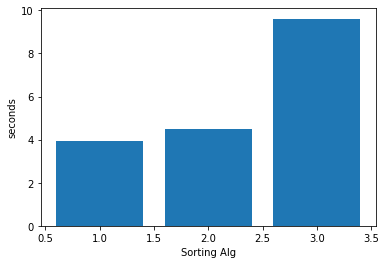

[3.918499735000296, 4.481905385000573, 9.614841139000418]

In [239]:
#Plotting the running times of each algorithm
import matplotlib.pyplot as plt
plt.ylabel('seconds')
plt.xlabel('Sorting Alg')
plt.bar([1,2,3],Times)
plt.show()
Times

As we can see, the InsertionSort algorithm is the best one of the non MapReduced algorithms

In [240]:
#implementing a MapReduced algorithm to confront the running times

def MergeSort(Rank,h):
    
    if len(Rank) == 1:
        return Rank

    l = len(Rank) // 2
    left = MergeSort(Rank[:l],h)
    right = MergeSort(Rank[l:],h)
    return merge(left, right,h)
#####################################
def merge(left, right,h):
    merged = []
    i = 0 
    j=0
    
    while i < len(left) and j < len(right):
        if left[i][h] > right[j][h]:
            merged.append(left[i])
            i += 1
        else:
            merged.append(right[j])
            j += 1
    merged.extend(left[i:])
    merged.extend(right[j:])
    return merged

In [241]:
Rank=unsorted #because the Rank list was already sorted by previous codes so I'll assign back the unsorted one
start=timeit.default_timer()
#sorting Rank by scores
Rank=MergeSort(Rank,1)
#sorting duplicates by names (Reusing previous algorithm)
i=0 
while i <= (len(Rank)-1):
        j=1
        while (i+j)<(len(Rank)-1) and Rank[i][1]==Rank[i+j][1]: #to know the length of consecutive elements that have same score
            j+=1
        if j!=1: 
            #temp variable to store the correct order (we used [::-1] to sort in ascending order)
            temp=MergeSort([Rank[i+k] for k in range(j)],0)[::-1] 
           
            for k in range(j):
                Rank[i+k]=temp[k] #changing the order in the Rank
            i+=j #just to skip the elements already changed
        else:
            i+=1
stop=timeit.default_timer()
Times.append(stop-start)

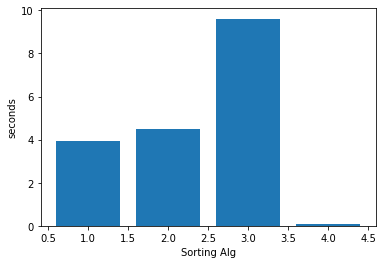

[3.918499735000296, 4.481905385000573, 9.614841139000418, 0.09068306100016343]

In [242]:
#Plotting the running times
plt.ylabel('seconds')
plt.xlabel('Sorting Alg')
plt.bar([1,2,3,4],Times)
plt.show()
Times

In [243]:
#TOP TEN STUDENTS
assert len(Rank)>=10

for i in range(10):
    print(Rank[i][0]+' '+str(Rank[i][1]))
    


Michael Hunley 26.02
Robert Seelbach 25.94
Felicia Payne 25.88
Karen Viard 25.88
Nakia Loza 25.82
Walter Jones 25.76
Jasmine Harrell 25.72
Mary Perrella 25.66
Stanley Hartrick 25.64
Samuel Winfrey 25.6


In [244]:
F=open('RankingList.txt','w') #creating a .txt file with the sorted Applicants
for i in range(len(Rank)):
    F.write(Rank[i][0]+' '+str(Rank[i][1])+'\n')
F.close()